In [16]:
import os
import pandas as pd
import numpy as np
from pybaseball import pitching_stats
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [17]:
START = 2002
END = 2023

def next_season(player):
    player = player.sort_values("Season")
    player["Next_WAR"] = player["WAR"].shift(-1)
    return player

In [18]:
def backtest(data, model, predictors, start=9, step=1):
    all_predictions = []
    years = sorted(data["Season"].unique())

    for i in range(start, len(years), step):
        current_year = years[i]

        train = data[data["Season"] < current_year]
        test = data[data["Season"] == current_year]
    
        model.fit(train[predictors], train["Next_WAR"])
        preds = model.predict(test[predictors]) #returns a numpy array 
        preds = pd.Series(preds, index=test.index) #we do this to make it a Series
        combined = pd.concat([test[["Season", "Next_WAR"]], preds.rename("predictions")], axis=1) #combine the Series
        combined["actual"] = combined["Next_WAR"]
        combined = combined.drop("Next_WAR", axis=1)
    
        all_predictions.append(combined)

    return pd.concat(all_predictions)

In [19]:
pitching = pitching_stats(START, END, qual=50)

pitching.to_csv("pitching.csv")
pitching = pitching.groupby("IDfg", group_keys=False).filter(lambda x: x.shape[0] > 1)

pitching = pitching.groupby("IDfg", group_keys=False).apply(next_season)

null_count = pitching.isnull().sum()

complete_cols = list(pitching.columns[null_count == 0])
pitching = pitching[complete_cols + ["Next_WAR"]].copy()

pitching.dtypes

pitching.dtypes[pitching.dtypes == "object"]
del pitching["Dollars"]
del pitching["Age Rng"]
del pitching["Team"]

pitching_full = pitching.copy()
pitching = pitching.dropna()

In [20]:
# Setting up the model for ridge regrassion 
rr = Ridge(alpha=1.0)
spilt = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(rr, n_features_to_select=5, direction="forward", cv=spilt, n_jobs=4)

removed_columns = ["Next_WAR", "Name", "IDfg", "Season"]
selected_columns = pitching.columns[~pitching.columns.isin(removed_columns)]

scaler = MinMaxScaler()
pitching.loc[:, selected_columns] = scaler.fit_transform(pitching[selected_columns])

sfs.fit(pitching[selected_columns], pitching["Next_WAR"])

predictors = list(selected_columns[sfs.get_support()])


In [21]:
# Training the model
predictions = backtest(pitching, rr, predictors)

# Evaluating the model
pitching["Next_WAR"].describe()

mse = mean_squared_error(predictions["actual"], predictions["predictions"])
rmse = mse ** 0.5

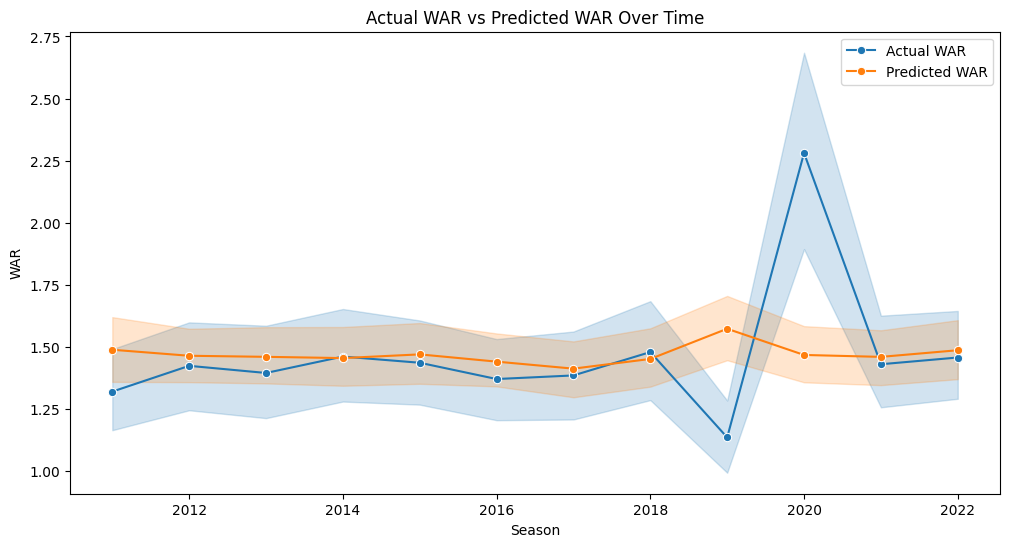

In [22]:
# Improving the model
plt.figure(figsize=(12, 6))

sns.lineplot(x='Season', y='actual', data=predictions, label='Actual WAR', marker='o')

sns.lineplot(x='Season', y='predictions', data=predictions, label='Predicted WAR', marker='o')

plt.title('Actual WAR vs Predicted WAR Over Time')
plt.xlabel('Season')
plt.ylabel('WAR')
plt.legend()

plt.show()